### Functions for downloading collection info and imagery

#### Format dates for STAC API query

In [2]:
from datetime import datetime, timedelta

input_date_str = "2022-03-01"
max_days_before = 21

max_date = datetime.strptime(input_date_str, "%Y-%m-%d") 
min_date = max_date - timedelta(days=max_days_before)

date_format = '%Y-%m-%dT%H:%M:%SZ'
stac_datetime = min_date.strftime(date_format) + '/' + max_date.strftime(date_format)
print(stac_datetime)

2022-02-08T00:00:00Z/2022-03-01T00:00:00Z


#### Query the STAC API for Sentinel-2 COGs

In [5]:
# Region in the Virunga mountains for DRC and Rwanda
geojson = {
    "type": "Polygon",
    "coordinates": [[
        (29.3688, -1.5118), 
        (29.3344, -1.4476), 
        (29.4516, -1.3251), 
        (29.6239, -1.3177), 
        (29.6114, -1.5008)
    ]]
}

In [23]:
from pystac import ItemCollection
from pystac_client import Client
from shapely.geometry import box, shape


polygon = shape(geojson)   
print(polygon.bounds)

client = Client.open("https://earth-search.aws.element84.com/v0")
search = client.search(
    bbox=polygon.bounds,
    collections=['sentinel-s2-l2a-cogs'], 
    datetime=stac_datetime,
    query={
        "eo:cloud_cover":{
            "lt":"30"
        },
    }
)

print(f"{search.matched()} items found")

items = list(search.items_as_dicts())
collection = ItemCollection(items=items)
collection.save_object('s2_collection.json')

(29.3344, -1.5118, 29.6239, -1.3177)
2 items found


#### Plot the region of interest and the Sentinel-2 image extents

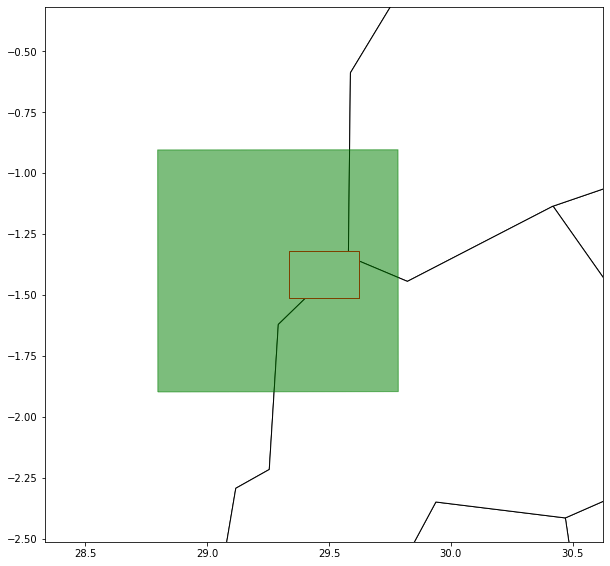

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

s2_list = [[i['id'], shape(i['geometry'])] for i in items]
s2_list.append(['bounds', box(*polygon.bounds)])
s2_df = pd.DataFrame(s2_list, columns=["id", "polygon"])

s2_gdf = gpd.GeoDataFrame(s2_df, geometry=s2_df.polygon)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black', figsize=(10, 10)) # AxesSubplot

ax = s2_gdf[-1:].plot(ax=base, color='white', edgecolor='red', alpha=1.0)
ax = s2_gdf[:-1].plot(ax=base, color='green', edgecolor='green', alpha=0.3)

minx, miny, maxx, maxy = s2_gdf[-1:].geometry.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)
plt.show()

#### Download image from collection

In [24]:
first = items[0]
# download all of the bands from first locally, not sure if it'll be one file or many